# Project 2: Breakout Strategy

## Importing Required Packages

In [541]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.stats import norm
from scipy.stats import kstest
%matplotlib inline

## Instructions

While using real data will give you hands on experience, it's doesn't cover all the topics we try to condense in one project. We'll solve this by creating new stocks. We've create a scenario where companies mining Terbium are making huge profits. All the companies in this sector of the market are made up. They represent a sector with large growth that will be used for demonstration latter in this project.

## Loading the Data into our DataFrame

We needed the data for this project and fortunately we also it on GitHub. So, we load the data into a pandas dataframe.

In [3]:
stock_data = pd.read_csv (r'https://github.com/scumabo/AI-for-Trading/raw/master/Projects/2-Breakout-strategy/eod-quotemedia.csv',  parse_dates=['date'], index_col=False)

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490737 entries, 0 to 490736
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       490737 non-null  datetime64[ns]
 1   ticker     490737 non-null  object        
 2   adj_close  490737 non-null  float64       
 3   adj_high   490737 non-null  float64       
 4   adj_low    490737 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 16.8+ MB


In [5]:
stock_data.tail()

,date,ticker,adj_close,adj_high,adj_low
490732,2017-06-26,ZTS,62.430093,62.629169,61.952312
490733,2017-06-27,ZTS,62.469909,62.907875,62.330556
490734,2017-06-28,ZTS,62.659030,63.166673,62.320602
490735,2017-06-29,ZTS,62.211110,62.987505,61.763190
490736,2017-06-30,ZTS,62.091665,62.639123,62.081711


This time around we'll use the `project_helper` that Udacity has provided for the projects, however, I don't have Plotly at the moment and I am running a Windows PC, so it as been a nightmare to install node.js as it doesn't support windows 7 anymore. So I'll use StackOverflow to somehow circumvent that problem or I'll have to make do with Matplotlib for this project.

Below are two functions that we'll need to generate new stocks for companies mining Terbium. We are not writing our own functions this time around as the coding skills required are not upto par for the job and this is not part of the course requirement either but rather a helper. However, I have given each function careful consideration and tried to understand each and every part of it.

The function below takes a set of dates and defines a set of `stock_names` each of which is looped through and sent to the `_generate_second_tetration_stocks` function. The function below will return a list with elements as a column of data with each ticker as the column name. For each iteration we only send the first six characters of the name of the stock which is treated as the Ticker for the stock. As you may have noticed that Tickers can only be upto 4 letters whereas here there are 6, implying fake stocks.

In [6]:
def generate_tb_sector(dates):
    """
    Generate TB sector of stocks
    :param dates: Dates that stocks should have market data on
    :return: TB sector stocks
    """
    symbol_length = 6
    stock_names = [
        'kaufmanniana', 'clusiana', 'greigii', 'sylvestris', 'turkestanica', 'linifolia', 'gesneriana',
        'humilis', 'tarda', 'saxatilis', 'dasystemon', 'orphanidea', 'kolpakowskiana', 'praestans',
        'sprengeri', 'bakeri', 'pulchella', 'biflora', 'schrenkii', 'armena', 'vvedenskyi', 'agenensis',
        'altaica', 'urumiensis']

    return [
        _generate_second_tetration_stock(stock_name[:symbol_length].upper(), dates)
        for stock_name in stock_names]

The function below, using dates as an index for length, will create the column and fill it with the necessary data in this case, a second <a href="https://en.wikipedia.org/wiki/Tetration" target="_blank">Tetration curve</a> i.e., $x^{x}$, for a single stock.

`np.linspace()` returns numbers spaced evenly w.r.t an interval in this case `len(dates)`. So this will create `len(dates)` no. of points between 1 and 5. The next function `np.random.rand` creates an array of the given shape and populate it with random samples in a uniform distribution in $[0,1)$, in this case 5 rows and `len(dates)` columns. Some constants are added to this, perhaps to make the fuction more realistic as the Tetration curve blows up very quickly. Now we create a pandas data frame with three columns as 'ticker', 'date', and 'base line'. We then go on to append the columns for 'adj_open', 'adj_close' and others, using the 2D array we creates with random numbers to account for volatility in the stock prices. To make sure that 'adj_high' is the maximum while 'adj_low' is the minimum we calculate the max. and min. of the three columns, including 'adj_open' and 'adj_close'. Then we return this dataframe after dropping the column 'base line'.

In [7]:
def _generate_second_tetration_stock(stock_symbol, dates):
    """
    Generate stock that follows the second tetration curve
    :param stock_symbol: Stock Symbol
    :param dates: Dates for ticker
    :return: Stock data
    """
    n_stock_columns = 5
    linear_line = np.linspace(1, 5, len(dates))
    all_noise = ((np.random.rand(n_stock_columns, len(dates)) - 0.5) * 0.01)
    sector_stock = pd.DataFrame({
        'ticker': stock_symbol,
        'date': dates,
        'base_line': np.power(linear_line, linear_line)})

    sector_stock['base_line'] = sector_stock['base_line'] + all_noise[0]*sector_stock['base_line']
    sector_stock['adj_open'] = sector_stock['base_line'] + all_noise[1]*sector_stock['base_line']
    sector_stock['adj_close'] = sector_stock['base_line'] + all_noise[2]*sector_stock['base_line']
    sector_stock['adj_high'] = sector_stock['base_line'] + all_noise[3]*sector_stock['base_line']
    sector_stock['adj_low'] = sector_stock['base_line'] + all_noise[4]*sector_stock['base_line']

    sector_stock['adj_high'] = sector_stock[['adj_high', 'adj_open', 'adj_close']].max(axis=1)
    sector_stock['adj_low'] = sector_stock[['adj_low', 'adj_open', 'adj_close']].min(axis=1)

    return sector_stock.drop(columns='base_line')

Now we need to generate these fictious stocks and concatenate them to our dataframe. We'll do that below.

In [8]:
df = stock_data
df = pd.concat([df] + generate_tb_sector(df[df['ticker'] == 'AAPL']['date']), ignore_index=True)

We create a list of the dates using `df[df['ticker'] == 'AAPL']['date']` and pass it on to `generate_tb_sector` and concatenate the returned result to df.

Now we need to reshape the dataframe to use it, with the Tickers as columns, the date as index and prices as the values. We'll use the `pandas.pivot()` function to do just that.

In [133]:
close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')
high = df.reset_index().pivot(index='date', columns='ticker', values='adj_high')
low = df.reset_index().pivot(index='date', columns='ticker', values='adj_low')

In [134]:
close.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,29.994186,16.176093,81.138217,53.109173,34.924478,50.863198,31.425388,64.694095,46.235,39.913360,...,27.668791,35.288928,76.320802,40.023873,22.106665,25.753386,45.480383,71.898827,27.858587,29.447893
2013-07-02,29.650137,15.819834,80.722073,54.312247,35.428076,50.696766,31.272881,64.712041,46.030,39.860576,...,27.542284,35.059033,76.608168,39.965530,22.082740,25.613675,45.402661,72.934172,28.038932,28.572441
2013-07-03,29.705185,16.127950,81.237299,54.612043,35.444862,50.937167,30.725650,65.214519,46.420,40.186077,...,27.334452,35.280086,76.650427,40.004426,22.202365,25.734758,46.063299,72.301458,28.181310,28.168387
2013-07-05,30.434568,16.214608,81.821882,54.173381,35.856134,51.371737,31.326707,66.075911,47.000,40.652334,...,27.695899,35.801771,77.394196,40.675380,22.585164,26.060750,46.413048,73.164246,29.396267,29.024598
2013-07-08,30.524021,16.310894,82.951417,53.865799,36.661889,52.037461,31.766285,66.820655,46.625,40.256455,...,27.985057,35.200507,77.968926,40.646208,22.489464,26.228403,46.950626,73.892823,29.576612,29.765365


## The Alpha Research Process:

In this project you will code and evaluate a "breakout" signal. It is important to understand where these steps fit in the alpha research workflow. The signal-to-noise ratio in trading signals is very low and, as such, it is very easy to fall into the trap of overfitting to noise. It is therefore inadvisable to jump right into signal coding. To help mitigate overfitting, it is best to start with a general observation and hypothesis; i.e., you should be able to answer the following question before you touch any data:
- What feature of markets or investor behaviour would lead to a persistent anomaly that my signal will try to use?
Ideally the assumptions behind the hypothesis will be testable before you actually code and evaluate the signal itself. The workflow therefore is as follows:
![alpha](alpha_steps.png)
In this project, we assume that the first three steps area done ("observe & research", "form hypothesis", "validate hypothesis"). The hypothesis you'll be using for this project is the following:
- In the absence of news or significant investor trading interest, stocks oscillate in a range.
- Traders seek to capitalize on this range-bound behaviour periodically by selling/shorting at the top of the range and     buying/covering at the bottom of the range. This behaviour reinforces the existence of the range.
- When stocks break out of the range, due to, e.g., a significant news release or from market pressure from a large investor:
  - the liquidity traders who have been providing liquidity at the bounds of the range seek to cover their positions to mitigate losses, thus magnifying the move out of the range, and
  - the move out of the range attracts other investor interest; these investors, due to the behavioural bias of herding (e.g., Herd Behavior) build positions which favor continuation of the trend.
  
Using this hypothesis, let start coding..

## Compute the Highs and Lows

You'll use the price highs and lows as an indicator for the breakout strategy. In this section, implement `get_high_lows_lookback` to get the maximum high price and minimum low price over a window of days. The variable `lookback_days` contains the number of days to look in the past. Make sure this doesn't include the current day.

In [69]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high_max : DataFrame
        Lookback high price for each ticker and date
    lookback_low_min : DataFrame
        Lookback low price for each ticker and date
    """
    lookback_high = high.shift(1).rolling(window=lookback_days).max() # we use the .rolling function to get a rolling windo
    lookback_low = low.shift(1).rolling(window=lookback_days).min() # to not include the current day the data is shifted by 1

    return lookback_high, lookback_low


In [70]:
lookback_days = 50
lookback_high, lookback_low = get_high_lows_lookback(high, low, lookback_days)

In [71]:
lookback_high

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,60.467218,51.505207,151.310045,154.235804,71.254719,95.961038,48.618958,126.108324,147.45,88.153685,...,43.582731,67.16178,80.481508,65.164093,27.763079,53.909207,74.099221,129.103038,43.205254,63.549893
2017-06-27,60.467218,51.505207,151.310045,154.235804,71.254719,95.961038,48.618958,126.108324,147.45,88.153685,...,43.582731,67.16178,80.481508,65.164093,28.059959,54.215677,74.197462,129.103038,43.205254,63.549893
2017-06-28,60.467218,51.505207,151.310045,154.235804,71.254719,95.961038,48.618958,126.108324,147.45,88.153685,...,43.582731,67.16178,80.481508,65.164093,28.155727,54.215677,74.197462,129.103038,43.205254,63.549893


Let's plot to see how the data looks like for Apple stock. Wherever possible I have created a clone of the the plotly code in Matplotlib and implemented it. Let's see it!

<function matplotlib.pyplot.show(close=None, block=None)>

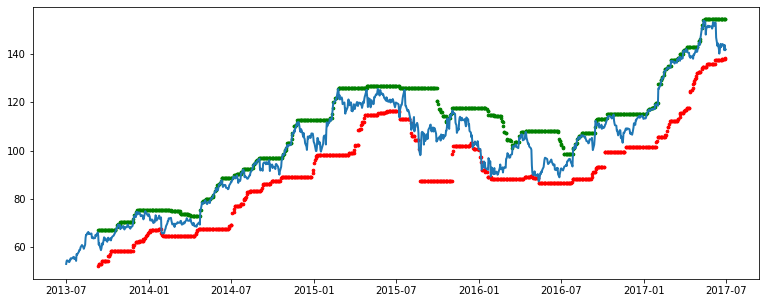

In [75]:
plt.figure(figsize=(13,5))
plt.plot(close.index, close['AAPL'], linewidth=2)
plt.scatter(lookback_high.index, lookback_high.shift(-1)['AAPL'], s=7, color='green')
plt.scatter(lookback_low.index, lookback_low.shift(-1)['AAPL'], s=7, color='red')
plt.show

## Compute Long and Short Signals

Using the generated indicator of highs and lows, create long and short signals using a breakout strategy. Implement
`get_long_short` to generate the following signals:
<br>                                  ![signal](signal.png)

In this chart, Close Price is the `close` parameter. Low and High are the values generated from `get_high_lows_lookback`, the `lookback_high` and `lookback_low` parameters.

At first these conditions didn't make any sense to me. How can the closing price be greater than the maximum for the past `lookback_days` number of days? How could the low be less than the minimum? Then I realised that I had shifted back the data frames to rectify the date mismatch. If I don't do that then the close price can be greater than the maximum of the past however number of days not including the current one.

In [72]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """
    long_short = pd.DataFrame(data=0, index=close.index, columns=close.columns)
    long_short[close > lookback_high] = 1
    long_short[close < lookback_low] = -1
    
    return long_short


In [178]:
long_short = get_long_short(close, lookback_high, lookback_low)

In [151]:
def _generate_buy_annotations(index, prices):
    return plt.annotate('Long', xy = (index, prices), xytext = (index, prices+10), arrowprops = dict(facecolor = 'green', shrink = 0.01))

def _generate_sell_annotations(index, prices):
    return plt.annotate('Short', xy = (index, prices), xytext = (index, prices-10), arrowprops = dict(facecolor = 'red', shrink = 0.01))

<function matplotlib.pyplot.show(close=None, block=None)>

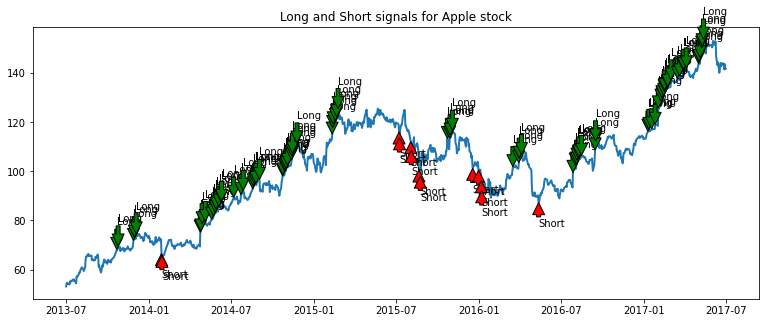

In [215]:
plt.figure(figsize=(13,5))
plt.title('Long and Short signals for Apple stock')
plt.plot(close.index, close['AAPL'], linewidth=2)
for index, prices in close['AAPL'][long_short['AAPL'] == 1].iteritems():
    _generate_buy_annotations(index, prices)
for index, prices in close['AAPL'][long_short['AAPL'] == -1].iteritems():
    _generate_sell_annotations(index, prices)
plt.show

## Filter Signals

That was a lot of repeated signals! If we're already shorting a stock, having an additional signal to short a stock isn't helpful for this strategy. This also applies to additional long signals when the last signal was long.

Implement `filter_signals` to filter out repeated long or short signals within the `lookahead_days`. If the previous signal was the same, change the signal to 0 (do nothing signal). For example, say you have a single stock time series that is
<br>`[1, 0, 1, 0, 1, 0, -1, -1]`
<br>Running `filter_signals` with a lookahead of 3 days should turn those signals into
<br>`[1, 0, 0, 0, 1, 0, -1, 0]`
<br>To help you implement the function, we have provided you with the `clear_signals` function. This will remove all signals within a window after the last signal. For example, say you're using a windows size of 3 with `clear_signals`. It would turn the Series of long signals
<br>`[0, 1, 0, 0, 1, 1, 0, 1, 0]`
<br> into
<br>`[0, 1, 0, 0, 0, 1, 0, 0, 0]`
<br> `clear_signals` only takes a Series of the same type of signals, where 1 is the signal and 0 is no signal. It can't take a mix of long and short signals. Using this function, implement `filter_signals`.
<br>For implementing `filter_signals`, we don't reccommend you try to find a vectorized solution. Instead, you should use the `iterrows` over each column.

In [200]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]

    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int), signals.index)


In [201]:
def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    long = signal.copy()
    short = signal.copy()
    long[long == -1] = 0
    short[short == 1] = 0
    for column in signal.columns:
        long[column] = clear_signals(long[column], lookahead_days)
        short[column] = clear_signals(short[column], lookahead_days)
    
    return long+short

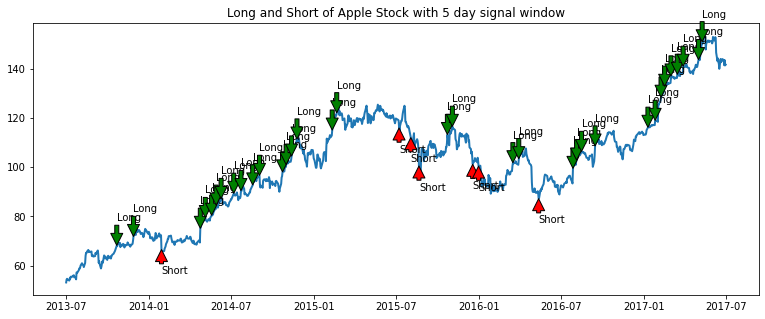

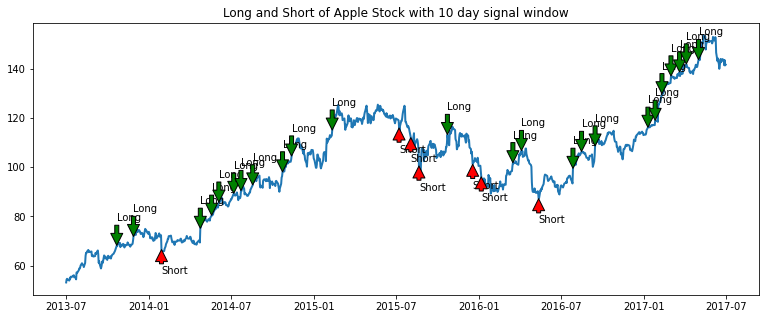

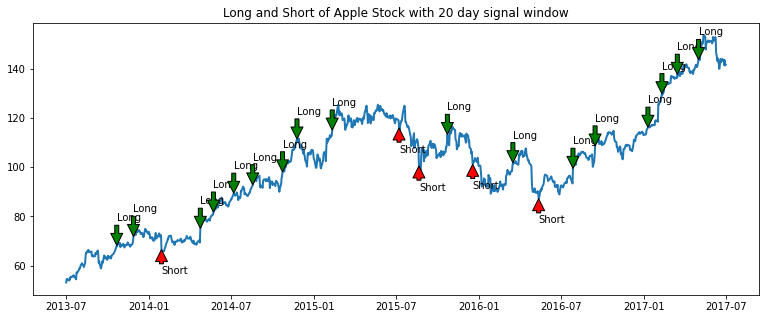

In [571]:
signal_5 = filter_signals(long_short, 5)
signal_10 = filter_signals(long_short, 10)
signal_20 = filter_signals(long_short, 20)
for signal_data, signal_days in [(signal_5, 5), (signal_10, 10), (signal_20, 20)]:
    plt.figure(figsize =(13,5))
    plt.title('Long and Short of {} Stock with {} day signal window'.format('Apple', signal_days))
    plt.plot(close.index, close['AAPL'], linewidth=2)
    for index, prices in close['AAPL'][signal_data['AAPL']==1].iteritems():
        _generate_buy_annotations(index, prices)
    for index, prices in close['AAPL'][signal_data['AAPL']==-1].iteritems():
        _generate_sell_annotations(index, prices)
    plt.show

## Lookahead Close Prices

With the trading signal done, we can start working on evaluating how many days to short or long the stocks. In this problem, implement `get_lookahead_prices` to get the close price days ahead in time. You can get the number of days from the variable `lookahead_days`. We'll use the lookahead prices to calculate future returns in another problem.

In [217]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    return close.shift(-lookahead_days)

In [360]:
lookahead_prices_5 = get_lookahead_prices(close, 5)
lookahead_prices_10 = get_lookahead_prices(close, 10)
lookahead_prices_20 = get_lookahead_prices(close, 20)
lookahead_prices_10

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,31.590573,17.283385,81.623718,55.831340,37.106964,53.886696,32.153210,67.556427,47.485,42.684510,...,29.042290,38.273146,78.856377,40.860135,23.278988,26.619594,46.569362,76.816704,28.067408,29.977012
2013-07-02,31.384143,17.764817,80.741889,55.846264,37.234013,54.062373,32.261288,67.439781,48.040,42.807673,...,29.186869,38.489778,78.991608,40.937927,23.183288,26.666164,46.458746,78.302616,28.067408,29.813466
2013-07-03,31.583692,17.735931,81.742617,56.034188,37.538933,53.914435,32.153210,67.691020,48.190,42.526159,...,29.557353,40.523467,79.769184,41.229646,23.494313,26.945586,46.979292,78.810700,28.779297,29.649921
2013-07-05,31.790121,17.552987,81.455279,55.150636,37.708332,54.376743,32.306320,67.493618,48.070,42.209456,...,29.710968,40.549993,80.436886,41.249094,23.207213,26.815189,46.901210,81.168980,28.997609,29.091940
2013-07-08,32.202980,17.475958,81.990322,55.327139,38.089481,54.543174,32.243275,67.296215,48.280,42.174267,...,29.846511,40.594204,80.149520,41.492193,23.470388,26.889702,46.504294,81.025182,29.272873,29.120801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Lookahead Price Returns

Implement `get_return_lookahead` to generate the log price return between the closing price and the lookahead price.

In [220]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    return np.log(lookahead_prices) - np.log(close)

In [361]:
lookahead_returns_5 = get_return_lookahead(close, lookahead_prices_5)
lookahead_returns_10 = get_return_lookahead(close, lookahead_prices_10)
lookahead_returns_20 = get_return_lookahead(close, lookahead_prices_20)
lookahead_returns_10

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.051855,0.066211,0.005966,0.049986,0.060617,0.057744,0.022896,0.043293,0.026677,0.067125,...,0.048448,0.081179,0.032683,0.020679,0.051672,0.033081,0.023662,0.066162,0.007468,0.017808
2013-07-02,0.056836,0.115955,0.000245,0.027853,0.049718,0.064276,0.031117,0.041288,0.042741,0.071330,...,0.057996,0.093359,0.030638,0.024040,0.048635,0.040269,0.022994,0.071024,0.001015,0.042518
2013-07-03,0.061319,0.095039,0.006201,0.025708,0.057400,0.056805,0.045414,0.037271,0.037421,0.056599,...,0.078185,0.138563,0.039882,0.030167,0.056560,0.045977,0.019690,0.086204,0.020997,0.051259
2013-07-05,0.043577,0.079312,-0.004491,0.017879,0.050366,0.056848,0.030792,0.021229,0.022511,0.037588,...,0.070232,0.124538,0.038561,0.014006,0.027170,0.028538,0.010463,0.103826,-0.013654,0.002317
2013-07-08,0.053545,0.068993,-0.011654,0.026768,0.038200,0.047029,0.014904,0.007092,0.034881,0.046540,...,0.064397,0.142565,0.027584,0.020600,0.042693,0.024900,-0.009552,0.092144,-0.010323,-0.021893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute the Signal Return

Using the price returns generate the signal returns.

In [223]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    #TODO: Implement function
    
    return signal * lookahead_returns

In [362]:
signal_return_5 = get_signal_return(signal_5, lookahead_returns_5)
signal_return_10 = get_signal_return(signal_10, lookahead_returns_10)
signal_return_20 = get_signal_return(signal_20, lookahead_returns_20)
signal_return_10

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-05,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
2013-07-08,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It would better to view one column of the data instead of the whole dataframe for a clearer picture. So, let's look at the Apple stock.

In [363]:
# removing the NaN values and zeros from the column
signal_return_10['AAPL'][(signal_return_10['AAPL']!=0) & ~(np.isnan(signal_return_10['AAPL']))]

date
2013-10-21    0.010281
2013-11-27    0.026355
2014-01-28   -0.062469
2014-04-24    0.040573
2014-05-19    0.053066
2014-06-04    0.000682
2014-07-07   -0.021369
2014-07-23   -0.023212
2014-08-18    0.040903
2014-10-23    0.040566
2014-11-12    0.067344
2015-02-10    0.053998
2015-07-08   -0.021390
2015-08-03    0.006360
2015-08-21   -0.032650
2015-10-23    0.020782
2015-12-18    0.031813
2016-01-06    0.044677
2016-03-16    0.028100
2016-04-04   -0.033306
2016-05-12   -0.105681
2016-07-27    0.053257
2016-08-15   -0.024597
2016-09-14    0.019317
2017-01-09    0.008202
2017-01-25    0.080068
2017-02-09    0.031517
2017-03-01    0.004781
2017-03-20    0.015711
2017-04-04   -0.028658
2017-05-01    0.064444
Name: AAPL, dtype: float64

## Test for Significance

### Histogram

Let's plot a histogram of our signals.

First, we'll create a function that will attach all the necessary features that I want my histogram to show. We do that below.
Let's start with one ticker after which we'll move onto the entire dataframe. We first plot the log return for Apple stock.

In [563]:
def get_ticker_historgram_subplot(signal_return, ticker, subplot_index, signal_window):
    # clearing a list with the non zero and non NaN values of each ticker
    x = signal_return[ticker][(signal_return[ticker]!=0) & ~(np.isnan(signal_return[ticker]))]
    # defining constants
    n_bins = 20
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs[0, subplot_index].spines[s].set_visible(False)
        
    # Remove x, y ticks
    axs[0, subplot_index].xaxis.set_ticks_position('none')
    axs[0, subplot_index].yaxis.set_ticks_position('none')

    # Add x, y gridlines
    axs[0, subplot_index].grid(b = True, color ='grey',
             linestyle ='-.', linewidth = 0.5,
             alpha = 0.6)

    # Creating histogram
    n, bins, patches = axs[0, subplot_index].hist(x, bins = n_bins)
    
    # Setting color
    n_index = [i for i in range(0, n_bins)] # using index to colour from left to right
    norm_ = colors.Normalize(0, n_bins)

    for index, thispatch in zip(n_index, patches):
        colour = plt.cm.RdYlGn(norm_(index))
        thispatch.set_facecolor(colour)
        
    # Adding extra features    
    axs[0, subplot_index].set_xlabel("Log Returns")
    axs[0, subplot_index].set_ylabel("Frequency")
    axs[0, subplot_index].title.set_text("'AAPL' Log Returns for {} days Signal Window".format(signal_window))

<function matplotlib.pyplot.show(close=None, block=None)>

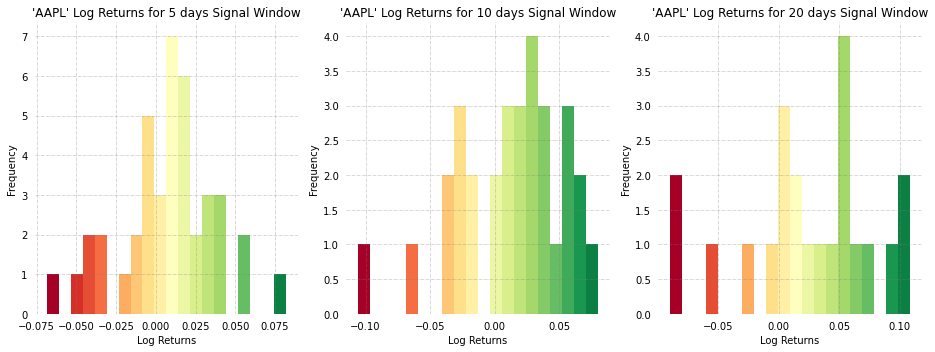

In [564]:
index = 0 # to index the subplots
# Creating subplots
fig, axs = plt.subplots(1, 3, squeeze = False,
                            figsize =(13, 5),
                            tight_layout = True)
# Creating Histogram and adding features
for signal_return, days in [[signal_return_5, 5], [signal_return_10, 10], [signal_return_20, 20]]:
    get_ticker_historgram_subplot(signal_return, 'AAPL', index, days)
    index += 1
# Displaying the plot    
plt.show

We can see that the data is approimately normally distributed with a slight positie bias. The 5 days returns are the closest to normal while the 10 days returns have the most positive bias.

Now let's move onto plotting the entire dataframe. We'll make a few changes to our subplot function and then plot it.

In [566]:
def get_historgram_subplot(signal_return, subplot_index, signal_window):
    # clearing a list with the non zero and non NaN values of each ticker
    x = [list(signal_return[ticker][(signal_return[ticker]!=0) & ~(np.isnan(signal_return[ticker]))].values) 
                                                                                                   for ticker in close.columns]
    data = []
    for i in range(0, len(x)):
        data = data + x[i]
    data.sort()
    # defining constants
    n_bins = 100
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs[subplot_index, 0].spines[s].set_visible(False)
        
    # Remove x, y ticks
    axs[subplot_index, 0].xaxis.set_ticks_position('none')
    axs[subplot_index, 0].yaxis.set_ticks_position('none')

    # Add x, y gridlines
    axs[subplot_index, 0].grid(b = True, color ='grey',
             linestyle ='-.', linewidth = 0.5,
             alpha = 0.6)

    # Creating histogram
    n, bins, patches = axs[subplot_index, 0].hist(data, bins = n_bins)
    
    # Setting color
    n_index = [i for i in range(0, n_bins)] # using index to colour from left to right
    norm_ = colors.Normalize(0, n_bins)

    for index, thispatch in zip(n_index, patches):
        colour = plt.cm.RdYlGn(norm_(index))
        thispatch.set_facecolor(colour)
        
    # Adding extra features    
    axs[subplot_index, 0].set_xlabel("Log Returns")
    axs[subplot_index, 0].set_ylabel("Frequency")
    axs[subplot_index, 0].title.set_text("Log Returns for {} days Signal Window".format(signal_window))

Now we can move on to creating the plots. 

<function matplotlib.pyplot.show(close=None, block=None)>

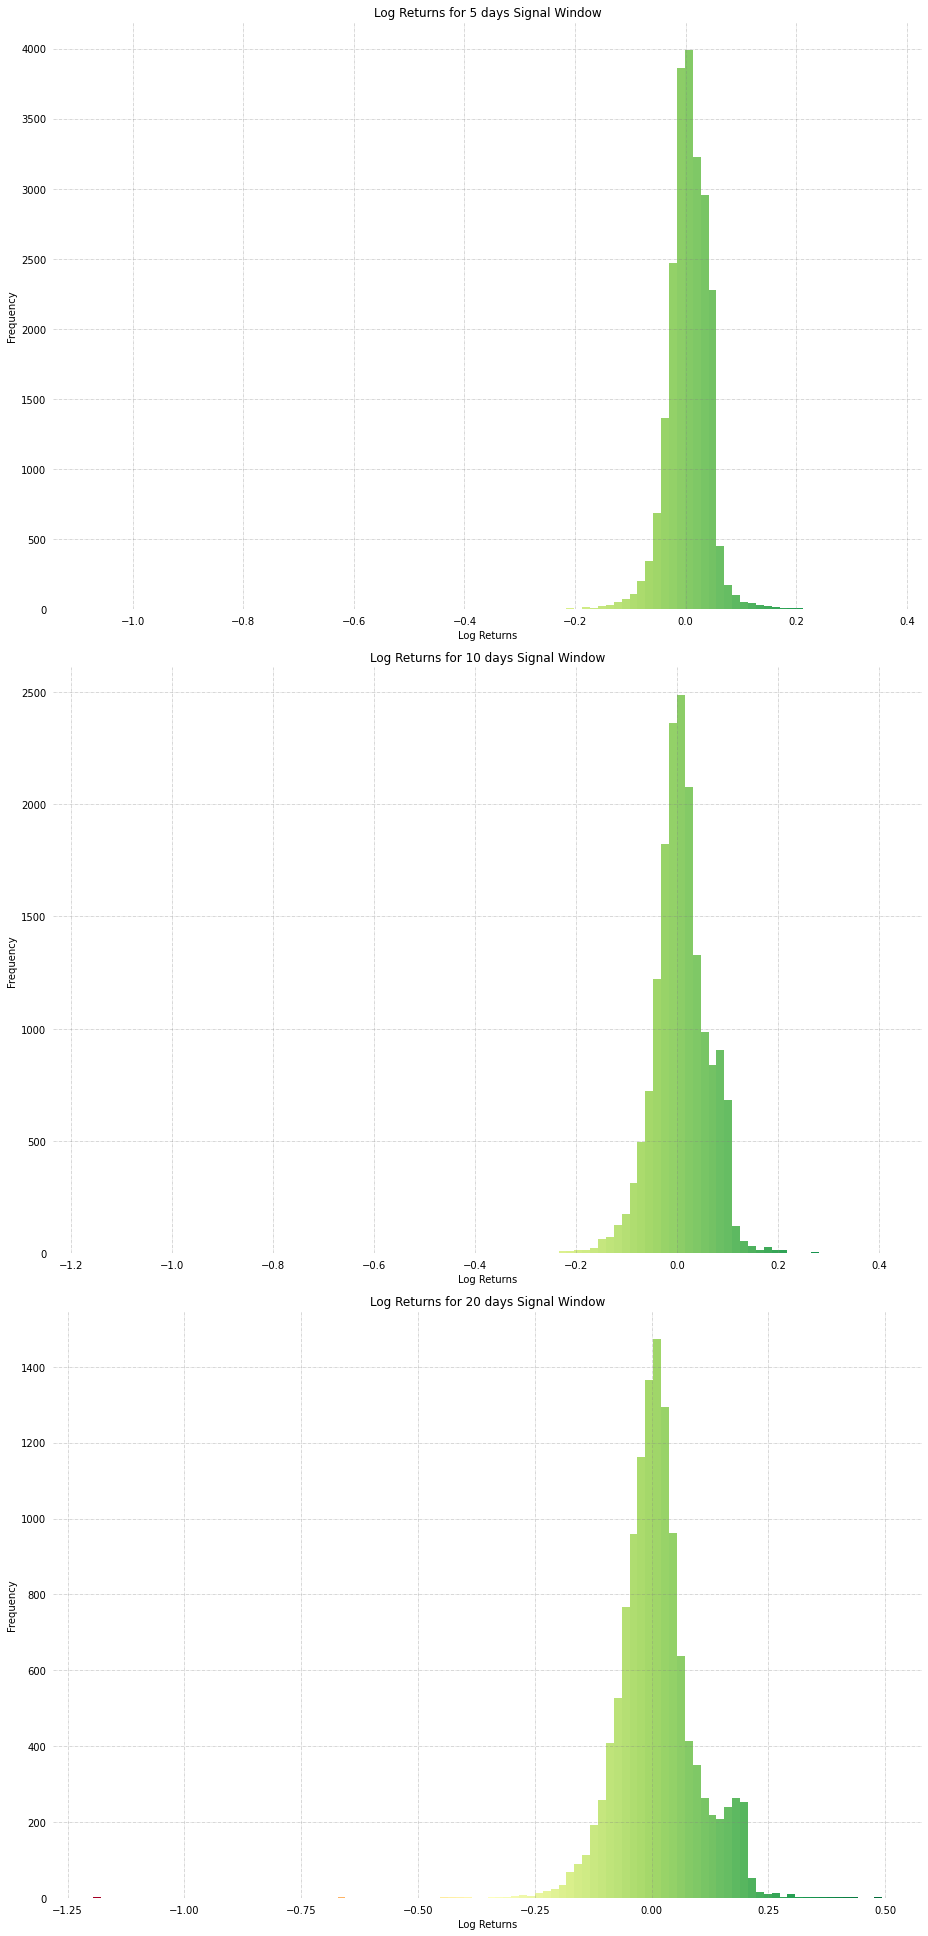

In [565]:
index = 0 # to index the subplots
# Creating subplots
fig, axs = plt.subplots(3, 1, squeeze = False,
                            figsize =(13, 27),
                            tight_layout = True)
# Creating Histogram and adding features
for signal_return, days in [[signal_return_5, 5], [signal_return_10, 10], [signal_return_20, 20]]:
    get_historgram_subplot(signal_return, index, days)
    index += 1
# Displaying the plot    
plt.show

### Question: What do the histograms tell you about the signal returns?

I would say that the 5 day return signal is a reasonable approximation of the normal distribution. However, the outliers in the other two have skewed the data towards positive returns. Although, visible in all the histograms, this effect is more pronounced in the 10 day return and 20 day return histogram.

### Outliers

You might have noticed the outliers in the 10 and 20 day histograms. To better visualize the outliers, let's compare the 5, 10, and 20 day signals returns to normal distributions with the same mean and deviation for each signal return distributions. We'll simply reuse the function we created above after tweaking it a bit to add the normal pdf.

In [581]:
def get_histogram_subplot_with_normpdf(signal_return, ticker, subplot_index, signal_window):
    # clearing a list with the non zero and non NaN values of each ticker
    x = signal_return[ticker][(signal_return[ticker]!=0) & ~(np.isnan(signal_return[ticker]))]
    # defining constants
    n_bins = 20
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs[0, subplot_index].spines[s].set_visible(False)
        
    # Remove x, y ticks
    axs[0, subplot_index].xaxis.set_ticks_position('none')
    axs[0, subplot_index].yaxis.set_ticks_position('none')

    # Add x, y gridlines
    axs[0, subplot_index].grid(b = True, color ='grey',
             linestyle ='-.', linewidth = 0.5,
             alpha = 0.6)

    # Creating histogram
    n, bins, patches = axs[0, subplot_index].hist(x, bins = n_bins)
    
    # Setting color
    n_index = [i for i in range(0, n_bins)] # using index to colour from left to right
    norm_ = colors.Normalize(0, n_bins)
    for index, thispatch in zip(n_index, patches):
        colour = plt.cm.RdYlGn(norm_(index))
        thispatch.set_facecolor(colour)
        
    # Adding Normal distribution    
    mean = statistics.mean(x)
    sd = statistics.stdev(x)
    axs[0, subplot_index].plot(x.sort_values(), norm.pdf(x.sort_values(), mean, sd)) # we need to sort the values for a proper
    # plot, otherwise, it will keep running back and forth between different points
        
    # Adding extra features    
    axs[0, subplot_index].set_xlabel("Log Returns")
    axs[0, subplot_index].set_ylabel("Frequency")
    axs[0, subplot_index].title.set_text("'APPL' Log Returns for {} days Signal Window".format(signal_window))

<function matplotlib.pyplot.show(close=None, block=None)>

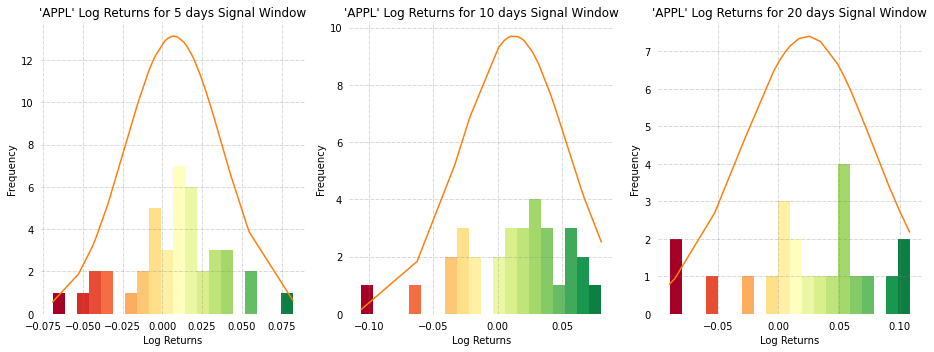

In [582]:
index = 0 # to index the subplots
# Creating subplots
fig, axs = plt.subplots(1, 3, squeeze = False,
                            figsize =(13, 5),
                            tight_layout = True)
# Creating Histogram and adding features
for signal_return, days in [[signal_return_5, 5], [signal_return_10, 10], [signal_return_20, 20]]:
    get_histogram_subplot_with_normpdf(signal_return, 'AAPL', index, days)
    index += 1
# Displaying the plot    
plt.show

In [595]:
def get_histogram_subplot_with_normpdf(signal_return, subplot_index, signal_window):
    # clearing a list with the non zero and non NaN values of each ticker
    x = [list(signal_return[ticker][(signal_return[ticker]!=0) & ~(np.isnan(signal_return[ticker]))].values) 
                                                                                                   for ticker in close.columns]
    data = []
    for i in range(0, len(x)):
        data = data + x[i]
    data.sort()
    # defining constants
    n_bins = 100
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        axs[subplot_index, 0].spines[s].set_visible(False)
        
    # Remove x, y ticks
    axs[subplot_index, 0].xaxis.set_ticks_position('none')
    axs[subplot_index, 0].yaxis.set_ticks_position('none')

    # Add x, y gridlines
    axs[subplot_index, 0].grid(b = True, color ='grey',
             linestyle ='-.', linewidth = 0.5,
             alpha = 0.6)

    # Creating histogram
    n, bins, patches = axs[subplot_index, 0].hist(data, bins = n_bins)
    
    # Setting color
    n_index = [i for i in range(0, n_bins)] # using index to colour from left to right
    norm_ = colors.Normalize(0, n_bins)

    for index, thispatch in zip(n_index, patches):
        colour = plt.cm.RdYlGn(norm_(index))
        thispatch.set_facecolor(colour)
    
    # Adding Normal distribution    
    mean = statistics.mean(data)
    sd = statistics.stdev(data)
    axs[subplot_index, 0].plot(data, norm.pdf(data, mean, sd)) # we need to sort the values for a proper
    # plot, otherwise, it will keep running back and forth between different points
        
    # Adding extra features 
    axs[subplot_index, 0].set_ylim(0, 100)
    axs[subplot_index, 0].set_xlabel("Log Returns")
    axs[subplot_index, 0].set_ylabel("Frequency")
    axs[subplot_index, 0].title.set_text("Log Returns for {} days Signal Window".format(signal_window))

<function matplotlib.pyplot.show(close=None, block=None)>

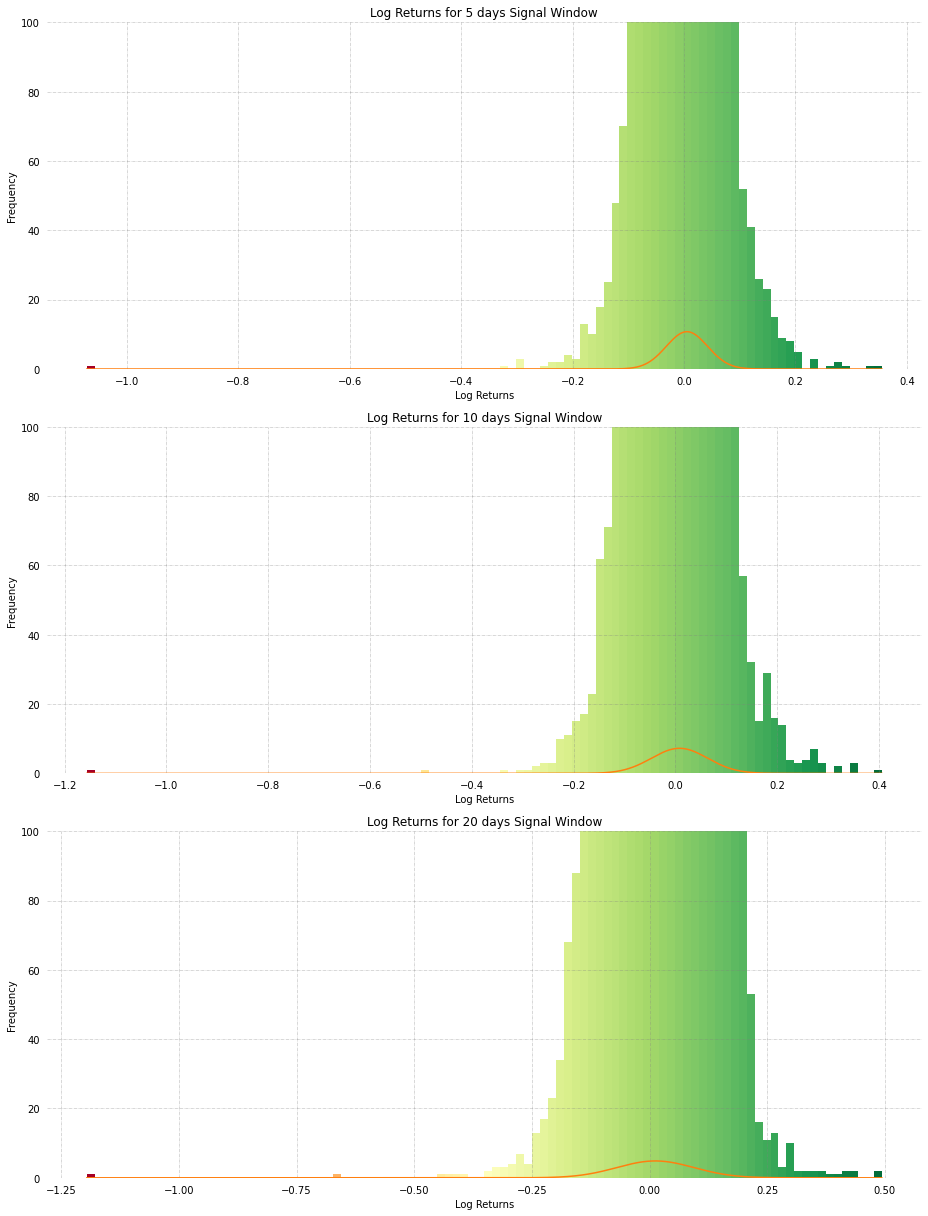

In [596]:
index = 0 # to index the subplots
# Creating subplots
fig, axs = plt.subplots(3, 1, squeeze = False,
                            figsize =(13, 17),
                            tight_layout = True)
# Creating Histogram and adding features
for signal_return, days in [[signal_return_5, 5], [signal_return_10, 10], [signal_return_20, 20]]:
    get_histogram_subplot_with_normpdf(signal_return, index, days)
    index += 1
# Displaying the plot 
plt.show

## Kolmogorov-Smirnov Test

While you can see the outliers in the histogram, we need to find the stocks that are causing these outlying returns. We'll use the Kolmogorov-Smirnov Test or KS-Test. This test will be applied to teach ticker's signal returns where a long or short signal exits.

In [440]:
# Filter out returns that don't have a long or short signal.
long_short_signal_returns_5 = signal_return_5[signal_5 != 0].stack()
long_short_signal_returns_10 = signal_return_10[signal_10 != 0].stack()
long_short_signal_returns_20 = signal_return_20[signal_20 != 0].stack()

# Get just ticker and signal return
long_short_signal_returns_5 = long_short_signal_returns_5.reset_index().iloc[:, [1,2]]
long_short_signal_returns_5.columns = ['ticker', 'signal_return']
long_short_signal_returns_10 = long_short_signal_returns_10.reset_index().iloc[:, [1,2]]
long_short_signal_returns_10.columns = ['ticker', 'signal_return']
long_short_signal_returns_20 = long_short_signal_returns_20.reset_index().iloc[:, [1,2]]
long_short_signal_returns_20.columns = ['ticker', 'signal_return']

# View some of the data
long_short_signal_returns_5.head(10)

,ticker,signal_return
0,A,0.007326
1,ABC,0.016396
2,ADP,0.009815
3,AKAM,0.044005
4,ALGN,0.015456
5,APC,0.003059
6,ARMENA,0.014601
7,BA,0.080613
8,BCR,0.009334
9,BIIB,0.041762


This gives you the data to use in the KS-Test.

Now it's time to implement the function `calculate_kstest` to use Kolmogorov-Smirnov test (KS test) between a distribution of stock returns (the input dataframe in this case) and each stock's signal returns. Run KS test on a normal distribution against each stock's signal returns. Use scipy.stats.kstest perform the KS test. When calculating the standard deviation of the signal returns, make sure to set the delta degrees of freedom to 0.

For this function, we don't reccommend you try to find a vectorized solution. Instead, you should iterate over the groupby function.

In [489]:
def calculate_kstest(long_short_signal_returns):
    """
    Calculate the KS-Test against the signal returns with a long or short signal.
    
    Parameters
    ----------
    long_short_signal_returns : DataFrame
        The signal returns which have a signal.
        This DataFrame contains two columns, "ticker" and "signal_return"
    
    Returns
    -------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    """
    # Calculating Mean and Standard Deviation
    population_mean = long_short_signal_returns['signal_return'].mean()
    population_std = long_short_signal_returns['signal_return'].std(ddof = 0)
    # Grouping the returns by Ticker name
    grouped_returns = long_short_signal_returns.groupby(['ticker'])
    # Creating a list of ticker names
    ticker_list = [ticker for ticker, group in grouped_returns]
    # Creating a dict with ks static as keys and p value as values
    ks_p_dict = {l[0]:l[1] for l in [kstest(group['signal_return'].values,'norm',args=(population_mean, population_std))
                                     for ticker, group in grouped_returns]}
    # we can directly put the keys and values into a series as Python 3.6 and later preserve insertion order in dictionaries
    return pd.Series(ks_p_dict.keys(), index=ticker_list), pd.Series(ks_p_dict.values(), index=ticker_list)


In [491]:
ks_values_5, p_values_5 = calculate_kstest(long_short_signal_returns_5)
ks_values_10, p_values_10 = calculate_kstest(long_short_signal_returns_10)
ks_values_20, p_values_20 = calculate_kstest(long_short_signal_returns_20)

### View Data

In [494]:
print('ks_values_5')
print(ks_values_5.head(10))
print('p_values_5')
print(p_values_5.head(10))

ks_values_5
A       0.171796
AAL     0.107461
AAP     0.196631
AAPL    0.155839
ABBV    0.167825
ABC     0.214211
ABT     0.213391
ACN     0.281907
ADBE    0.242377
ADI     0.194002
dtype: float64
p_values_5
A       0.188724
AAL     0.690870
AAP     0.045596
AAPL    0.245547
ABBV    0.248479
ABC     0.027232
ABT     0.048870
ACN     0.005931
ADBE    0.009248
ADI     0.099744
dtype: float64


## Find Outliers

With the ks and p values calculate, let's find which symbols are the outliers. Implement the `find_outliers` function to find the following outliers:

- Symbols that pass the null hypothesis with a p-value less than `pvalue_threshold`.
- Symbols that with a KS value above `ks_threshold`.

In [496]:
def find_outliers(ks_values, p_values, ks_threshold, pvalue_threshold=0.05):
    """
    Find outlying symbols using KS values and P-values
    
    Parameters
    ----------
    ks_values : Pandas Series
        KS static for all the tickers
    p_values : Pandas Series
        P value for all the tickers
    ks_threshold : float
        The threshold for the KS statistic
    pvalue_threshold : float
        The threshold for the p-value
    
    Returns
    -------
    outliers : set of str
        Symbols that are outliers
    """
    #TODO: Implement function
    ks_index = ks_values[(ks_values > ks_threshold)].index
    p_index = p_values[(p_values < pvalue_threshold)].index
    
    return set(ks_index) and set(p_index)


### View Data

Using the `find_outliers` function you implemented, let's see what we found.

In [597]:
ks_threshold = 0.8
outliers_5 = find_outliers(ks_values_5, p_values_5, ks_threshold)
outliers_10 = find_outliers(ks_values_10, p_values_10, ks_threshold)
outliers_20 = find_outliers(ks_values_20, p_values_20, ks_threshold)

outlier_tickers = outliers_5.union(outliers_10).union(outliers_20)
print('{} Outliers Found:\n{}'.format(len(outlier_tickers), ', '.join(list(outlier_tickers))))

24 Outliers Found:
ORPHAN, LINIFO, SYLVES, GESNER, URUMIE, PRAEST, SPRENG, KAUFMA, GREIGI, DASYST, BAKERI, KOLPAK, BIFLOR, CLUSIA, ARMENA, VVEDEN, HUMILI, TURKES, SCHREN, TARDA, SAXATI, AGENEN, ALTAIC, PULCHE


### Show Significance without Outliers

Let's compare the 5, 10, and 20 day signals returns without outliers to normal distributions. Also, let's see how the P-Value has changed with the outliers removed.

<function matplotlib.pyplot.show(close=None, block=None)>

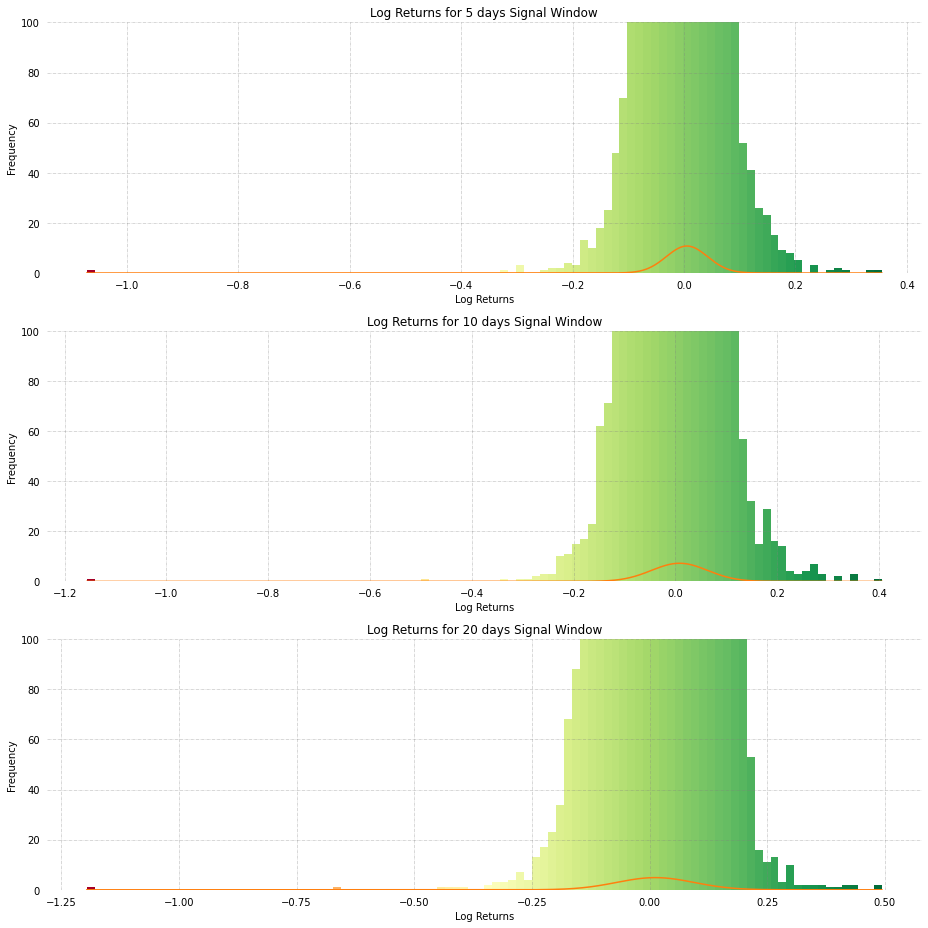

In [599]:
good_tickers = list(set(close.columns) - outlier_tickers)

index = 0 # to index the subplots
# Creating subplots
fig, axs = plt.subplots(3, 1, squeeze = False,
                            figsize =(13, 13),
                            tight_layout = True)
# Creating Histogram and adding features
for signal_return, days in [[signal_return_5, 5], [signal_return_10, 10], [signal_return_20, 20]]:
    get_histogram_subplot_with_normpdf(signal_return, index, days)
    index += 1
# Displaying the plot    
plt.show

## Conlusion

The projects and what they want to achieve seems quite easy and coding it is no big deal. However, I feel like I spend most of my time in trying to get the graphs to look right. So I keep going back and forth on Matplotlib and Seaborn. I have made do with MatPlotLib here. Hopefully, by next time I can use Plotly.